In [3]:
pip install arch openpyxl

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install seaborn

C:\Users\Aditya Sakpal\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Aditya Sakpal\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Aditya Sakpal\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Aditya Sakpal\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Aditya Sakpal\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supporte

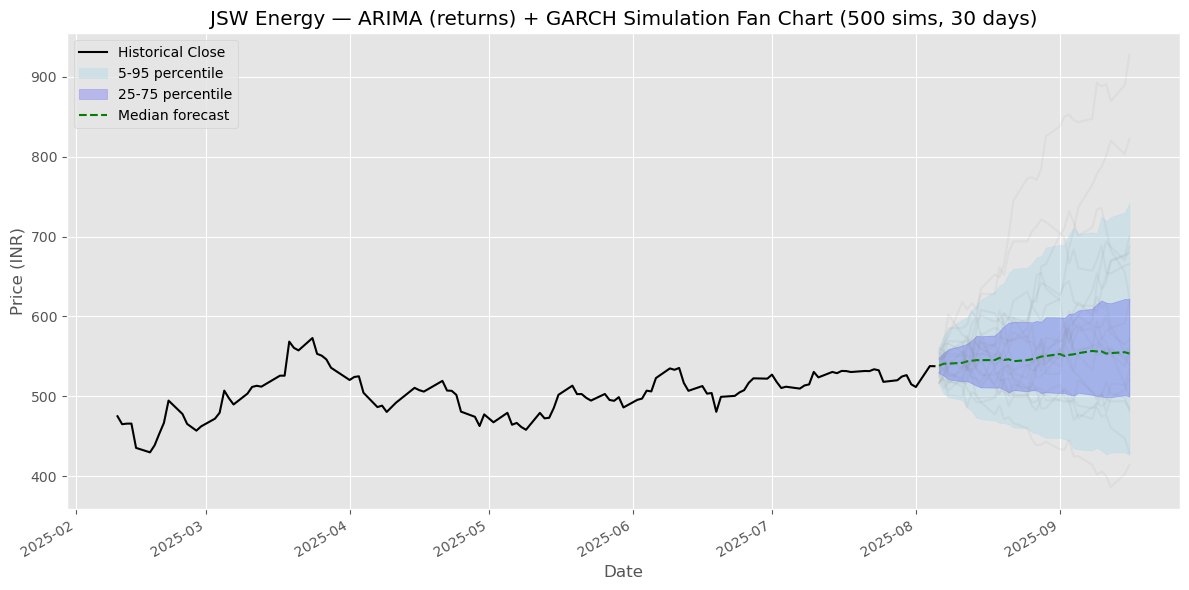

Saved: JSW_ARIMA_GARCH_Simulation.xlsx and JSW_ARIMA_GARCH_FanChart.png


In [7]:
# ---- ARIMA-on-returns + GARCH + Monte Carlo Fan Chart (paste into your notebook) ----
# Requirements: arch, statsmodels, sklearn, pandas, matplotlib, openpyxl (for Excel)
# If arch is not installed in your kernel, uncomment the pip install line below and restart kernel:
# !pip install arch openpyxl

import sqlite3, pandas as pd, numpy as np, matplotlib.pyplot as plt, os
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
from sklearn.metrics import mean_squared_error, mean_absolute_error
from datetime import timedelta

# -------------------- USER PARAMETERS --------------------
DB_PATH = "D:/Resume/Projects/JSW Energy/jswe_stock_data.db"    # update path if needed
HORIZON = 30                       # days to simulate ahead (business days)
N_SIMS = 500                       # Monte Carlo paths
ARIMA_ORDER = (1,0,1)              # ARIMA on log-returns (p,d,q)
SAVE_XLSX = "JSW_ARIMA_GARCH_Simulation.xlsx"
SAVE_PNG  = "JSW_ARIMA_GARCH_FanChart.png"
RANDOM_SEED = 42
# ---------------------------------------------------------

# Load data from SQLite
conn = sqlite3.connect(DB_PATH)
df = pd.read_sql("SELECT Date, Close FROM stock_prices", conn)
conn.close()
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)
df['Close'] = pd.to_numeric(df['Close'], errors='coerce')
df = df.dropna(subset=['Close']).reset_index(drop=True)

# Compute log-returns
df['log_price'] = np.log(df['Close'])
df['log_ret'] = df['log_price'].diff()
logret = df['log_ret'].dropna()

# Fit ARIMA on log-returns (train on all available returns)
arima_model = ARIMA(logret, order=ARIMA_ORDER).fit()
arima_fore = arima_model.get_forecast(steps=HORIZON)
mu = arima_fore.predicted_mean.values  # mean log-return forecast for each horizon step

# Fit GARCH(1,1) on ARIMA residuals
resid = arima_model.resid.dropna()
garch = arch_model(resid, vol='Garch', p=1, q=1)
garch_fit = garch.fit(disp='off')

# Forecast conditional variances for horizon
garch_fore = garch_fit.forecast(horizon=HORIZON, reindex=False)
var_fore = garch_fore.variance.values[-1]    # last row: variance for each horizon step
sigma = np.sqrt(var_fore)

# Monte Carlo simulation: draws for returns = mu + sigma * z
rng = np.random.default_rng(seed=RANDOM_SEED)
z = rng.normal(size=(N_SIMS, HORIZON))
returns_sim = mu.reshape(1, HORIZON) + sigma.reshape(1, HORIZON) * z  # log-returns simulated

# Convert to price paths starting from last observed price (use log-return accumulation)
last_price = df['Close'].iloc[-1]
cum_logret = np.cumsum(returns_sim, axis=1)
price_paths = last_price * np.exp(cum_logret)   # shape (N_SIMS, HORIZON)

# Percentile table per date
dates_future = pd.bdate_range(start=df['Date'].iloc[-1] + pd.Timedelta(days=1), periods=HORIZON)
percentiles = [5,25,50,75,95]
pct_df = pd.DataFrame(index=dates_future, columns=[f"P{p}" for p in percentiles])
for i, dt in enumerate(dates_future):
    pct_df.iloc[i] = np.percentile(price_paths[:, i], percentiles)

# Save results: history, sample simulated paths, percentiles
with pd.ExcelWriter(SAVE_XLSX, engine='openpyxl') as writer:
    df.to_excel(writer, sheet_name="history", index=False)
    # save first 200 sim paths to limit size
    sim_df = pd.DataFrame(price_paths[:200,:], columns=[d.strftime("%Y-%m-%d") for d in dates_future])
    sim_df.to_excel(writer, sheet_name="simulated_paths_sample", index=False)
    pct_df.to_excel(writer, sheet_name="percentiles")
    pd.DataFrame([{"last_price": float(last_price), "horizon_days": HORIZON, "n_sims": N_SIMS, "arima_order": ARIMA_ORDER}]).to_excel(writer, sheet_name="metadata", index=False)

# Plot fan chart
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(12,6))
# plot recent history for context
hist_plot_start = max(0, len(df)-120)
ax.plot(df['Date'].iloc[hist_plot_start:], df['Close'].iloc[hist_plot_start:], label='Historical Close', color='black')

# percentile bands
ax.fill_between(dates_future, pct_df['P5'].astype(float), pct_df['P95'].astype(float), color='lightblue', alpha=0.4, label='5-95 percentile')
ax.fill_between(dates_future, pct_df['P25'].astype(float), pct_df['P75'].astype(float), color='blue', alpha=0.2, label='25-75 percentile')
ax.plot(dates_future, pct_df['P50'].astype(float), color='green', linestyle='--', label='Median forecast')

# plot a few sampled paths for colour
for path in price_paths[np.random.choice(N_SIMS, size=20, replace=False), :]:
    ax.plot(dates_future, path, color='gray', alpha=0.08)

ax.set_title(f'JSW Energy — ARIMA (returns) + GARCH Simulation Fan Chart ({N_SIMS} sims, {HORIZON} days)')
ax.set_xlabel('Date'); ax.set_ylabel('Price (INR)'); ax.legend(loc='upper left')
fig.autofmt_xdate()
plt.tight_layout()
plt.savefig(SAVE_PNG, dpi=220)
plt.show()

print("Saved:", SAVE_XLSX, "and", SAVE_PNG)
# ---- end cell ----
